In [48]:
'''
Krotov Algorithm for Quantum gate Implementation
Written By Bilal Riaz

'''
import matplotlib
import scipy.stats
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
import scipy.linalg as LA
from scipy.integrate import ode


class Krotov:
    def __init__(self,w,lambda1,ti,tf,steps):
        self.w = float(w)
        self.lambda1 = float(lambda1)
        self.ti = ti
        self.tf = tf
        self.steps = steps
        self.t = np.linspace(ti,tf,steps)

        self.dt = self.t[1] - self.t[0]
        self.sX = np.array([[0, 1], [1, 0]], dtype = 'complex128')
        self.sY = np.array([[0, -1j], [1j, 0]], dtype = 'complex128')
        self.sZ = np.array([[1, 0], [0, -1]], dtype = 'complex128')
        self.I = np.array(np.identity(2), dtype = 'complex128')
        self.sD = np.array([[0, 1],[0, 0]], dtype = 'complex128')
        

        self.delta = 2.0
        self.alpha = 1.0

       # seed is given values for better debugging and Design Purposes
        rnd.seed(2)
        
        omega = 10;
        
        # Controls
        
        self.EX = 10 *rnd.rand(self.steps,) -5
        self.EX_tilde = np.zeros((self.steps,))

        self.Ui = np.identity(2, dtype = 'complex128')
        self.UT = 1j* np.array([[0, 1], [1, 0]], dtype = 'complex128')

        self.U = np.zeros([self.steps, 2, 2], dtype = 'complex128')
        self.B = np.zeros([self.steps, 2, 2], dtype = 'complex128')

        self.U[0] = np.identity(2, dtype = 'complex128')
        self.B[steps - 1] = self.UT.T.conj()

        self. Ho = self.w * self.sZ

    def Hc(self, t_index):
        t = t_index
        return (self.EX[t] * self.sX )

    def Hc_tilde(self, t_index):
        t = t_index
        return (self.EX_tilde[t] * self.sX )

    def H(self, t_index):
        t = t_index
        return (self.Ho + self.Hc(t))

    def H_tilde(self, t_index):
        t = t_index
        return (self. Ho + self.Hc_tilde(t))

    def update_U (self, t_index):
        t = t_index
        self.U[t+1] = np.dot(LA.expm(-1j * self.H(t) * self.dt), self.U[t])

    def update_B (self, t_index):
        t = t_index
        self.B[t-1] = np.dot( self.B[t], LA.expm(-1j * self.H_tilde(t) * self.dt))

    def update_E(self, t_index):
        t=t_index

        EX_part1 = (1-self.delta) * self.EX_tilde[t-1]
        EX_part2 = - self.delta * self.lambda1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sX, self.U[t]) ) ) )/ self.alpha
        self.EX[t] = -(EX_part1 + EX_part2)


    def update_E_tilde(self,t_index):
        t=t_index

        EX_part1 = (1 - self.delta) * self.EX[t]
        EX_part2 = -self.delta * self.lambda1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sX, self.U[t]) ) ) )/ self.alpha
        self.EX_tilde[t] = -(EX_part1 + EX_part2)

    def evolution_U(self,string='not initial'):
        if string == 'initial':
            for t in range(0,self.steps-1):
                self.update_U(t)
        else:
            for t in range(0,self.steps-1):
                self.update_E(t)
                self.update_U(t)
            t = self.steps-1
            self.update_E(t)

    def evolution_B(self):
        for t in range(self.steps-1,0,-1):
            self.update_E_tilde(t)
            self.update_B(t)
        t = 0
        self.update_E_tilde(t)

    def O(self,step):
        t = step
        return( np.dot(self.UT.conj().T, self.U[t] ))
    # Some methods might seem redundant but they are maintained to solve complicated optimal control problems in future
    # Better Structured Toolboxes can give 
    def Overlap(self, t_index ):
        t = t_index
        return( np.abs(np.trace(self.O(t))))

    def distance(self,t_index):
        t= t_index
        return(LA.norm(self.UT - self.U[t], 'fro'))

    def Run_Krotov(self, num_iter):
        T = self.steps-1
        self.evolution_U('initial')
        self.overlap = np.zeros([num_iter,1], dtype = 'float64')
        self.dis = np.zeros([num_iter,1], dtype = 'float64')

        for i in range(0,num_iter):
            #print (str(self.overlap[i]))
            self.B[T] = self.UT.conj().T
            self.evolution_B()
            self.evolution_U()
            self.overlap[i] = self.Overlap(T)
            self.dis[i] = self.distance(T)
            print ("Cycle : " + str(i) + ", infidelity = " + str(1-np.abs(self.Overlap(T))/2))


Cycle : 0, infidelity = 0.0387083725059445
Cycle : 1, infidelity = 0.03542948599358464
Cycle : 2, infidelity = 0.03432782506039456
Cycle : 3, infidelity = 0.03296847168279171
Cycle : 4, infidelity = 0.0318648812501553
Cycle : 5, infidelity = 0.03082853419187903
Cycle : 6, infidelity = 0.0297907606045702
Cycle : 7, infidelity = 0.028365523631716516
Cycle : 8, infidelity = 0.027501656029468746
Cycle : 9, infidelity = 0.026233383321808912
Cycle : 10, infidelity = 0.025006524939803265
Cycle : 11, infidelity = 0.024165053447340434
Cycle : 12, infidelity = 0.02304719404842226
Cycle : 13, infidelity = 0.021931664158063913
Cycle : 14, infidelity = 0.020965784497081863
Cycle : 15, infidelity = 0.01999496844810844
Cycle : 16, infidelity = 0.01876602619744283
Cycle : 17, infidelity = 0.017939544246768135
Cycle : 18, infidelity = 0.017123100190705953
Cycle : 19, infidelity = 0.016094525083627076
Cycle : 20, infidelity = 0.015349015474887873
Cycle : 21, infidelity = 0.014396686540415482
Cycle : 22,

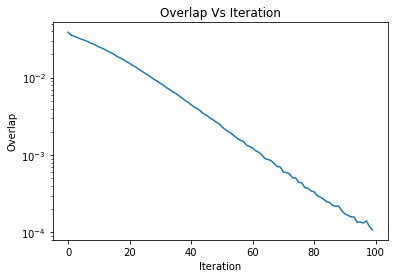

In [50]:
if __name__ == '__main__':
    # INTITIALIZE : w,lambda,ti,tf,steps
    k = Krotov(0.1, 1e-1, 0, 4,5000)
    k.Run_Krotov(100)
    
    s = Krotov(0.1, 0.5e-1 ,0, 4,5000)
    s.Run_Krotov(0)
    
    plt.figure(1)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.semilogy(1-np.abs(k.overlap)/2)


In [ ]:
plt.figure(3)
plt.title('Overlap Vs Iteration')
plt.ylabel('Overlap')
plt.xlabel('Iteration')
plt.semilogy(1-np.abs(k.overlap)/2)

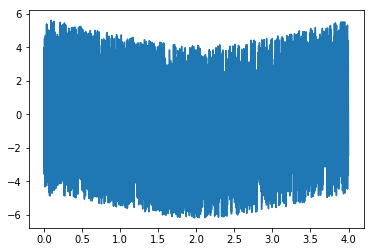

In [38]:
plt.figure(2)
plt.plot(k.t,k.EX)
plt.show()

In [36]:
k.U[k.steps-1]

array([[-0.00812022-0.04601799j, -0.01021992+0.99885871j],
       [ 0.01021998+0.99886366j, -0.00812047+0.04601831j]])